In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import OrdinalEncoder
import warnings
warnings.filterwarnings("ignore")

import joblib

In [14]:
train = pd.read_csv("../kaggle/input/playground-series-s4e12/train.csv")
test = pd.read_csv("../kaggle/input/playground-series-s4e12/test.csv")

sample = pd.read_csv('../kaggle/input/playground-series-s4e12/sample_submission.csv')
original = pd.read_csv('../kaggle/input/Insurance Premium Prediction Dataset.csv')

train.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True) 
original = original[train.columns]
original.drop('Premium Amount', axis=1, inplace=True)

In [15]:

def date(Df):
    Df['Policy Start Date'] = (pd.to_datetime(Df['Policy Start Date'])-pd.to_datetime('1/1/1970')).dt.days
    Df['Policy Start Date'] = pd.qcut(Df['Policy Start Date'], q=50, duplicates='raise')
    Df['Policy Start Date'] = OrdinalEncoder().fit_transform(Df[['Policy Start Date']])
    return Df

In [16]:
train = date(train)
test = date(test)
original = date(original)
# cat_c = [col for col in train.columns if train[col].dtype == 'object']

# def update(df):
#     global cat_c

#     for c in cat_c:
#         df[c] = df[c].fillna('None').astype('category')
                
#     return df

# train = update(train)
# test = update(test)

columns_to_convert = train.columns.difference(['Premium Amount'])

train[columns_to_convert] = train[columns_to_convert].fillna('None').astype('string')
test[columns_to_convert] = test[columns_to_convert].fillna('None').astype('string')
original[columns_to_convert] = original[columns_to_convert].fillna('None').astype('string')

In [17]:
X = train.drop('Premium Amount', axis=1)  
y = train['Premium Amount']
cat_features = X.columns.values

In [18]:
cat_features

array(['Age', 'Gender', 'Annual Income', 'Marital Status',
       'Number of Dependents', 'Education Level', 'Occupation',
       'Health Score', 'Location', 'Policy Type', 'Previous Claims',
       'Vehicle Age', 'Credit Score', 'Insurance Duration',
       'Policy Start Date', 'Customer Feedback', 'Smoking Status',
       'Exercise Frequency', 'Property Type'], dtype=object)

In [19]:
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [20]:
original.isna().sum()

Age                     0
Gender                  0
Annual Income           0
Marital Status          0
Number of Dependents    0
Education Level         0
Occupation              0
Health Score            0
Location                0
Policy Type             0
Previous Claims         0
Vehicle Age             0
Credit Score            0
Insurance Duration      0
Policy Start Date       0
Customer Feedback       0
Smoking Status          0
Exercise Frequency      0
Property Type           0
dtype: int64

In [21]:
def train():
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    oof = np.zeros(len(X))
    original_preds = np.zeros((len(original), 5))
    models = []

    for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
        print(f"Fold {fold + 1}")
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model = CatBoostRegressor(
            iterations=1000,
            learning_rate=0.1,
            depth=6,
            eval_metric="RMSE",
            random_seed=42,
            verbose=200,
            task_type='GPU',
            devices='0:1',
            l2_leaf_reg =  0.7,
        )
        
        model.fit(X_train,
                  y_train,
                  eval_set=(X_valid, y_valid), 
                  early_stopping_rounds=300,
                  cat_features=cat_features,
                 )
        models.append(model)
        oof[valid_idx] = np.maximum(0, model.predict(X_valid))
        fold_rmsle = rmsle(y_valid, oof[valid_idx])
        original_preds[:, fold] = np.maximum(0, model.predict(original))
        print(f"Fold {fold + 1} RMSLE: {fold_rmsle}")
        
    return models, oof, original_preds

In [22]:
models,oof, original_preds = train()

Fold 1
0:	learn: 862.9632891	test: 861.8774521	best: 861.8774521 (0)	total: 79.2ms	remaining: 1m 19s
200:	learn: 843.7475464	test: 839.3776285	best: 839.3776285 (200)	total: 17.1s	remaining: 1m 8s
400:	learn: 842.5148083	test: 838.9211205	best: 838.9211205 (400)	total: 37.8s	remaining: 56.5s
600:	learn: 841.4715441	test: 838.7599431	best: 838.7562805 (570)	total: 59.2s	remaining: 39.3s
800:	learn: 840.5079252	test: 838.6329244	best: 838.6249062 (773)	total: 1m 18s	remaining: 19.6s
999:	learn: 839.6006873	test: 838.6039040	best: 838.6025608 (944)	total: 1m 38s	remaining: 0us
bestTest = 838.6025608
bestIteration = 944
Shrink model to first 945 iterations.
Fold 1 RMSLE: 1.1429401744870396
Fold 2
0:	learn: 863.2659796	test: 861.1944970	best: 861.1944970 (0)	total: 83.7ms	remaining: 1m 23s
200:	learn: 844.0976070	test: 838.2295196	best: 838.2287866 (199)	total: 17.9s	remaining: 1m 11s
400:	learn: 842.7794827	test: 837.6406536	best: 837.6384124 (389)	total: 37s	remaining: 55.3s
600:	learn: 8

In [26]:
joblib.dump(original_preds, 'non_log_original_preds.pkl')

['non_log_original_preds.pkl']

In [9]:
print(rmsle(y, oof))

1.1408728857820265


In [45]:
test_predictions = np.zeros(len(test))

for model in models:
    test_predictions += np.maximum(0, model.predict(test)) / len(models)


sample['Premium Amount'] = test_predictions
sample.to_csv('submission.csv', index = False)

joblib.dump([oof,test_predictions],"cat_non_loged_simpler_date.pkl")

['cat_non_loged_simpler_date.pkl']

In [46]:
non_log_oof, non_log_test = joblib.load(
    '../kaggle/input/cat_non_loged_origin.pkl'
)

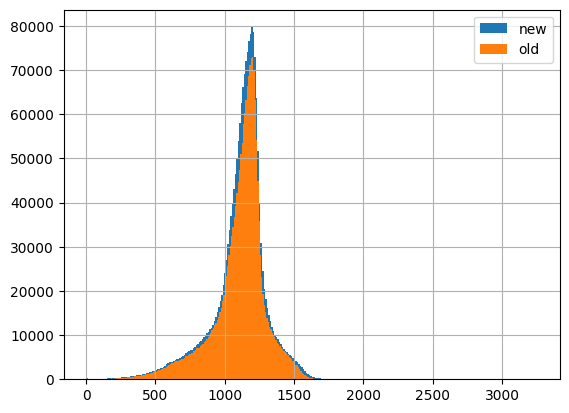

In [50]:
import matplotlib.pyplot as plt
m=pd.Series(np.hstack([oof, test_predictions]))#.to_pickle('cat_non_loged.pkl')
o=pd.Series(np.hstack([non_log_oof, non_log_test]))#.to_pickle('cat_non_loged_origin.pkl')
m.hist(bins=300)
o.hist(bins=300)
plt.legend(['new','old'])   

In [48]:
import winsound
frequency = 2500  # Set Frequency To 2500 Hertz
duration = 1000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)